<a href="https://colab.research.google.com/github/bayrameda/MrAP/blob/main/MrAP_FB15K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device( 'cpu')
print(device)

cpu


# Data Read

In [3]:
ent_100 = pd.read_csv('../KGs/FB15k-237-lit/train.txt', sep='\t', header=None)
ent_dev = pd.read_csv('../KGs/FB15k-237-lit/val.txt', sep='\t',header=None,)
ent_test = pd.read_csv('../KGs/FB15k-237-lit/test.txt' , sep='\t', header=None)

entities = pd.concat([ent_100, ent_dev, ent_test], ignore_index=True)
entities = entities.set_axis(['node', 'attribute', 'numeric'], axis=1)

triples = pd.read_csv('../KGs/FB15k-237-lit/FB15K-237_EntityTriples.txt', sep='\t', header=None, names= ['node_1', 'relation', 'node_2'])
triples = triples[triples['node_1'] != triples['node_2']]


In [4]:
from utils import extract_edges_FB, estimate_params, reduce_to_singles, performance, drop_sym

In [5]:
dates = ['people.person.date_of_birth',
          'film.film.initial_release_date',
          'organization.organization.date_founded',
          'location.dated_location.date_founded',
          'people.deceased_person.date_of_death']
corr_attributes = [dates,
                    ['people.person.weight_kg','people.person.height_meters'],
                    ['location.geocode.latitude'],
                    ['location.geocode.longitude'],
                    ['location.location.area','topic_server.population_number']]

In [6]:
edge_list = []
relations = []
for attributes in corr_attributes:
  entities_ofint = entities[entities.attribute.isin(attributes)]
  edge_ofint, rel_ofint = extract_edges_FB(triples, entities_ofint)
  edge_list = edge_list + edge_ofint
  relations = relations + rel_ofint

## Stats

In [7]:
entity_stat = pd.DataFrame(columns=['count','min', 'mean', 'max'])
attributes = entities['attribute'].unique().tolist()
for key in attributes:
  numerics = entities[entities['attribute']==key]['numeric']
  entity_stat.loc[key] = [len(numerics), numerics.min(),numerics.mean(),numerics.max()]
entity_stat

,count,min,mean,max
people.person.height_meters,2870.0,1.346000,1.760874e+00,2.180000e+00
location.geocode.latitude,3205.0,-90.000000,3.714623e+01,7.761361e+01
people.deceased_person.date_of_death,1218.0,-322.000000,1.962152e+03,2.015583e+03
location.geocode.longitude,3202.0,-175.200000,-3.618308e+01,1.792167e+02
people.person.date_of_birth,4424.0,-383.000000,1.940059e+03,1.999917e+03
location.dated_location.date_founded,922.0,-2999.000000,1.750624e+03,2.011583e+03
location.location.area,2165.0,0.004047,4.637813e+05,1.652500e+08
organization.organization.date_founded,1232.0,1088.000000,1.892702e+03,2.012000e+03
topic_server.population_number,1929.0,1.000000,5.975396e+06,3.130439e+09
film.film.initial_release_date,1867.0,1927.083333,1.996261e+03,2.013500e+03


### Multi-relational graph stats

In [8]:
print('Number of attribute types = ', entities['attribute'].nunique())
N = len(entities)
print('Total number of numerical facts = ', N)
print('Total number of entities = ',entities.node.nunique())
print('Total number of triple facts = ', len(triples))
print('Number of relation types = ',triples.relation.nunique())
print('Number of regression models = ', len(relations))
asym_edge_list = drop_sym(edge_list)
print('Number of message passing paths =', len(np.concatenate(asym_edge_list)))

Number of attribute types =  11
Total number of numerical facts =  23260
Total number of entities =  10072
Total number of triple facts =  308310
Number of relation types =  234
Number of regression models =  310
Number of message passing paths = 182730


In [9]:
attribute_labels = entities.attribute.values # corresponding entity labels of the nodes
x = entities.numeric.values.copy() # ordering of entities is compatible with the node ordering in triples

### Histogram demo

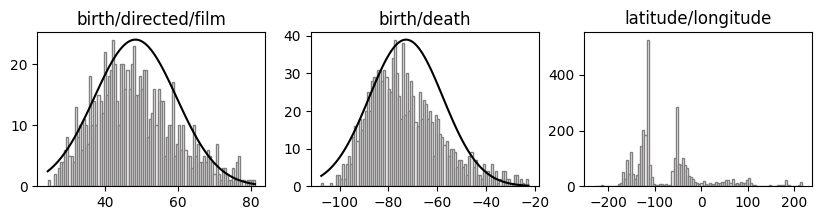

In [10]:
normal = lambda x, m, std, peak : peak*np.exp(-1/2*(x-m)**2/std**2)

def hist_plot(diff_pair, rel):
  bin_vals, bin_edges, _  = plt.hist(diff_pair, bins=100, color='snow', ec= 'grey');
  plt.plot(bin_edges, normal(bin_edges,diff_pair.mean(),diff_pair.std(),max(bin_vals)), 'k')
  plt.title(rel);

plt.figure(figsize=(10, 2));

pairs = edge_list[relations.index('/film/director/film')]
x_pairs = x[pairs]
diff_pair = x_pairs[:,1] - x_pairs[:,0]
plt.subplot(1,3,1)
hist_plot(diff_pair, 'birth/directed/film')

pairs = edge_list[relations.index('people.deceased_person.date_of_death_coupling')]
x_pairs = x[pairs]
diff_pair = x_pairs[:,1] - x_pairs[:,0]
plt.subplot(1,3,2)
hist_plot(diff_pair, 'birth/death')

lat_ent = entities[entities['attribute']=='location.geocode.latitude']
long_ent = entities[entities['attribute']=='location.geocode.longitude']
diff_pair = [long_ent[long_ent.node== node]['numeric'].item()- lat_ent[lat_ent.node== node]['numeric'].item() for node in lat_ent.node.to_list() if node in long_ent.node.to_list()]
diff_pair = np.array(diff_pair)
plt.subplot(1,3,3)
plt.hist(diff_pair, bins=100, color='snow', ec= 'grey');
plt.title('latitude/longitude');


#plt.savefig('histograms.pdf')

# Performances

In [11]:
def indices(entities_interest): #get the indicies of the entities of interest wrt x ordering
  return [entities[(entities.node == row[0]) & (entities.attribute == row[1])].index.item() for ind, row in entities_interest.iterrows()]

splits = ['100']
idx_train = [indices(item) for item in [ent_100]] #train = known, dev+test=unknown

def comp_u(idx):
  u = np.zeros(N, dtype=bool)
  u[idx] = 1
  return u

u_0_list = [comp_u(idx) for idx in idx_train]

#idx_val = indices(ent_dev)
idx_test = indices(ent_test)
idx_test_atts = [[item for item in idx_test if item in np.where(attribute_labels == att)[0]] for att in attributes]

Ratio known dates

In [12]:
print('Train=known, ratios=', [len(item)/N for item in idx_train])

Train=known, ratios= [0.8]


In [13]:
def get_performance(x_pred, u_0):
  tups = [performance(x_pred, x[idx], u_0, idx) for idx in idx_test_atts] # performance on each attribute type
  return [item for tupl in tups for item in tupl] #merging all

### Algorithms

In [14]:
from MrAP import MrAP
from algs import Global, Local, iter_MrAP

A variation : Reduction of the edges to the ones among single type of attribute \\
i.e., reduce the regression of one attribute from the same type of another

In [15]:
edge_list_singles, relations_singles, attribute_coupled = reduce_to_singles(edge_list, attribute_labels)
asym_edge_list_singles = drop_sym(edge_list_singles)

In [16]:
rel_to_scale = [relations.index(item) for item in ['people.person.weight_kg_coupling', 'topic_server.population_number_coupling']]
taus, omegas, etas, _ = estimate_params(edge_list, x, rel_to_scale)
tau_singles = taus[relations_singles]
omega_singles = omegas[relations_singles]
eta_singles = etas[relations_singles]

In [18]:
model = MrAP(device=device, edge_list=asym_edge_list, eta=etas, omega=omegas, tau=taus)

In [ ]:
table_result = pd.DataFrame(columns = [
    'height-RMSE', 'height-MAE',
    'lat-RMSE', 'lat-MAE',
    'death-RMSE', 'death-MAE',
    'long-RMSE', 'long-MAE',
    'birth-RMSE', 'birth-MAE',
    'date_founded-RMSE', 'date_founded-MAE',
    'area-RMSE', 'area-MAE',
    'org-RMSE', 'org-MAE',
    'pop-RMSE', 'pop-MAE',
    'film-RMSE', 'film-MAE',
    'weight-RMSE', 'weight-MAE'
])


kk=0
for u_00 in u_0_list:
  u_0 = torch.tensor(u_00, device=device)
  x_0 = torch.tensor(x, device=device)
  x_0[u_0 == 0] = 0 # Zero-padding of unknown

  x_pred = Global(x_0, u_0, attribute_labels)
  table_result.loc['Global-' + splits[kk]] = get_performance(x_pred, u_0)

  x_pred = Local(asym_edge_list, x_0, u_0, attribute_labels)
  table_result.loc['Local-' + splits[kk]] = get_performance(x_pred, u_0)

  x_pred = iter_MrAP(x_0, u_0, model, xi=0.5, entity_labels=attribute_labels)
  table_result.loc['MrAP_cross-' + splits[kk]]  = get_performance(x_pred, u_0)

  kk = kk+1

In [25]:
table_result


,height-RMSE,height-MAE,lat-RMSE,lat-MAE,death-RMSE,death-MAE,long-RMSE,long-MAE,birth-RMSE,birth-MAE,...,area-RMSE,area-MAE,org-RMSE,org-MAE,pop-RMSE,pop-MAE,film-RMSE,film-MAE,weight-RMSE,weight-MAE
Global-100,0.097217,0.079388,19.659801,12.402766,188.342251,56.560923,67.384904,58.391222,158.364972,35.801805,...,1.265433e+07,1.842883e+06,131.101854,81.028576,1.503801e+07,7.184317e+06,16.024871,12.200092,18.655968,12.505654
Local-100,255593.748968,126870.280448,112530.143763,24594.611888,46248.547370,4264.508871,99102.477900,19078.035808,76132.034312,11357.152517,...,1.387694e+07,4.366032e+06,145421.935635,41313.985624,3.079687e+08,9.215919e+07,130.808748,107.320476,249741.024965,121196.008929
MrAP_cross-100,0.102283,0.082259,3.813369,1.707035,24.816822,14.402354,14.385444,4.161509,45.068335,14.551100,...,1.225033e+07,1.893563e+06,102.773681,62.589455,1.260852e+08,2.429854e+07,7.946893,5.826835,13.129429,10.856814
